In [1]:
import sys
import scipy.io
import h5py
import numpy as np
import os, sys, time, subprocess, h5py, argparse, logging, pickle
import numpy as np
import pandas as pd
from os.path import join as oj
from copy import deepcopy
from scipy.ndimage import imread
import skimage
from PIL import Image
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path                   
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import data.data as data
import re
import seaborn as sns
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

import warnings
warnings.filterwarnings("ignore")
from lib.igg import binarywave

%matplotlib inline
%load_ext autoreload
%autoreload 2

# preprocess raw data

In [2]:
def read_conditions(fname):
    c_raw = pd.read_csv(fname, delimiter=',')
    c = pd.DataFrame() #pd.read_csv(oj('data', 'star_polymer_conditions.csv'), delimiter=',')
    c['fnames'] = c_raw.fnames.astype(str)
    c['conc'] = c_raw.conc_solution # mol/L
    c['solvent_glyc'] = [int(x[:2]) for x in c_raw.solvent_glyc]# percent glycerol, 5% ethanol, 85% water
    c['pressure'] = c_raw.pressure # mba  r
    c['time'] = c_raw.time # time delivered for (s)
    c['zmin'] = zz = [float(re.sub("[^0-9*.-]", "", zz).split('*')[0]) for zz in c_raw.zz] # physical width = physical height# max zscale
    c['zmax'] = zz = [float(re.sub("[^0-9*.-]", "", zz).split('*')[1]) for zz in c_raw.zz] # physical width = physical height# max zscale
    c['width_physical'] = [float(re.sub("[^0-9*.]", "", xy).split('*')[0]) for xy in c_raw.xy] # physical width = physical height
    c['R'] = c_raw.R # based on scan lines
    c['C'] = c_raw.C # based on scan lines
    return c
conditions = read_conditions(oj('data', 'star_polymer_conditions.csv'))

In [3]:
def read_ims(data_raw_dir, conditions):
    ims = []
    for fname in conditions['fnames']:
        try:
            data = binarywave.load(oj(data_raw_dir, fname + '.ibw'))['wave']
            ims.append(data['wData'][..., -1])
        except:
            print(fname)
    conditions['ims'] = ims
    return conditions

def preprocess_ims(dset):
    # images 3 and 33 have strange artifacts which require removal
    dset = dset.drop([3, 33], axis=0).reset_index()

    # preprocess images
    ims = deepcopy(dset.ims)
    for i in range(len(ims)):
        im = skimage.transform.resize(ims[i], (512, 512))
        im -= np.min(im)
        ims[i] = im

    # outliers (indexes after dropping)
    ims[21][ims[22] < 1e-8] = 1.17925154e-08 # image 21 has a couple very low points that ruin its contrast

    dset.ims = ims
    return dset
    
data_raw_dir = 'data/star_polymer/star_polymer_raw_ibw'
dset = read_ims(data_raw_dir, conditions)
dset = preprocess_ims(dset)

# plot all data

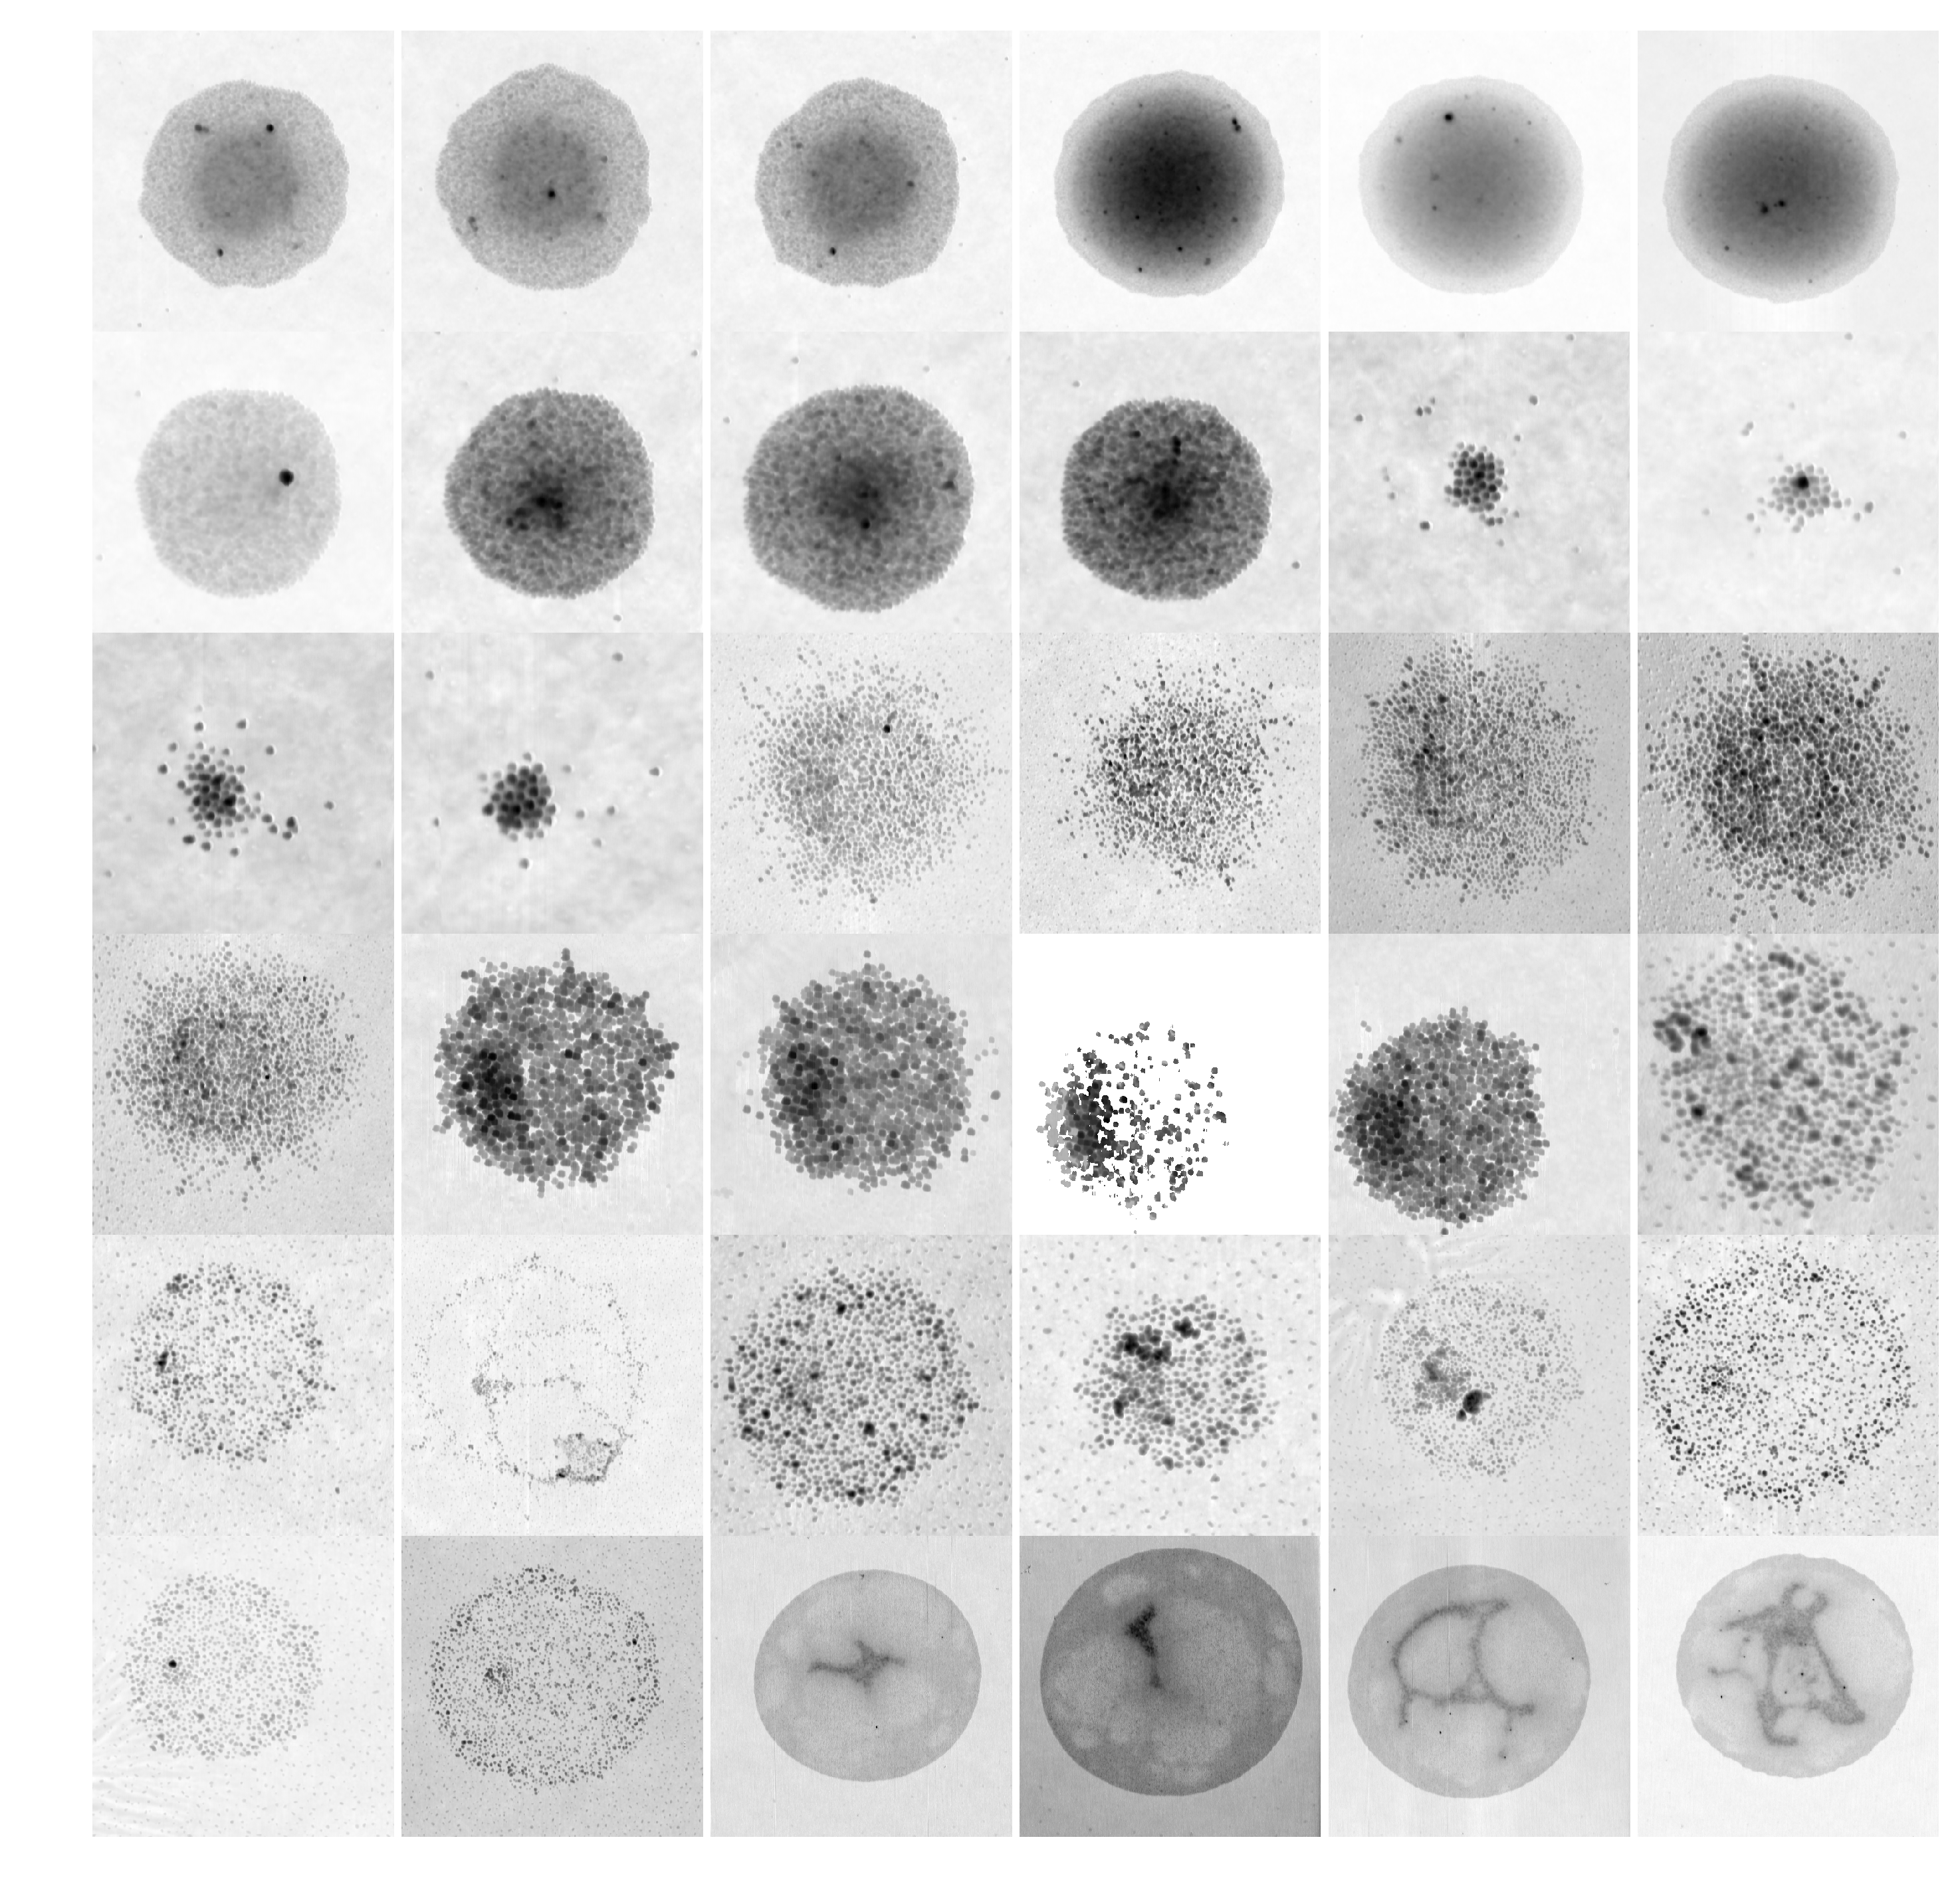

In [15]:
def plot_all(ims):
    plt.figure(figsize=(12, 12), dpi=300, facecolor='white')
    R, C = 6, 6
    for i in range(len(ims)):
        plt.subplot(R, C, i+1)
        im = ims[i]
        plt.imshow(im, cmap='gray_r')
        plt.axis('off')
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig('nano_results/dset_summaries_new/star_summ.pdf')
    plt.show()
plot_all(dset.ims)

# fix up scales

In [5]:
# adjust for width_physical

# maybe also adjust for R, C and check zmin/zmax

# data density

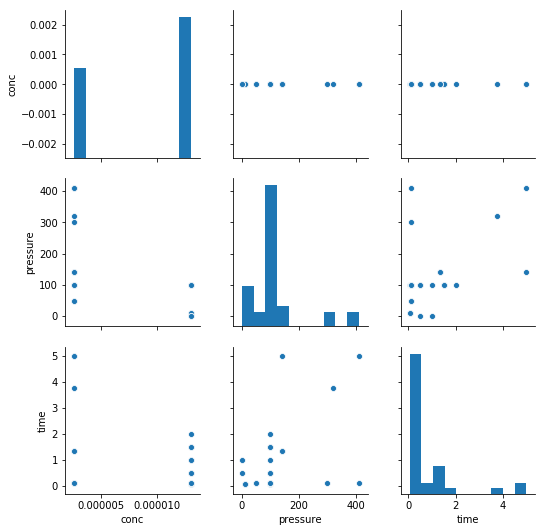

In [6]:
ivs = ['conc', 'pressure', 'time'] # to a lesser extent, solvent_glyc
ivs_df = dset[ivs]
sns.pairplot(ivs_df)
plt.show()

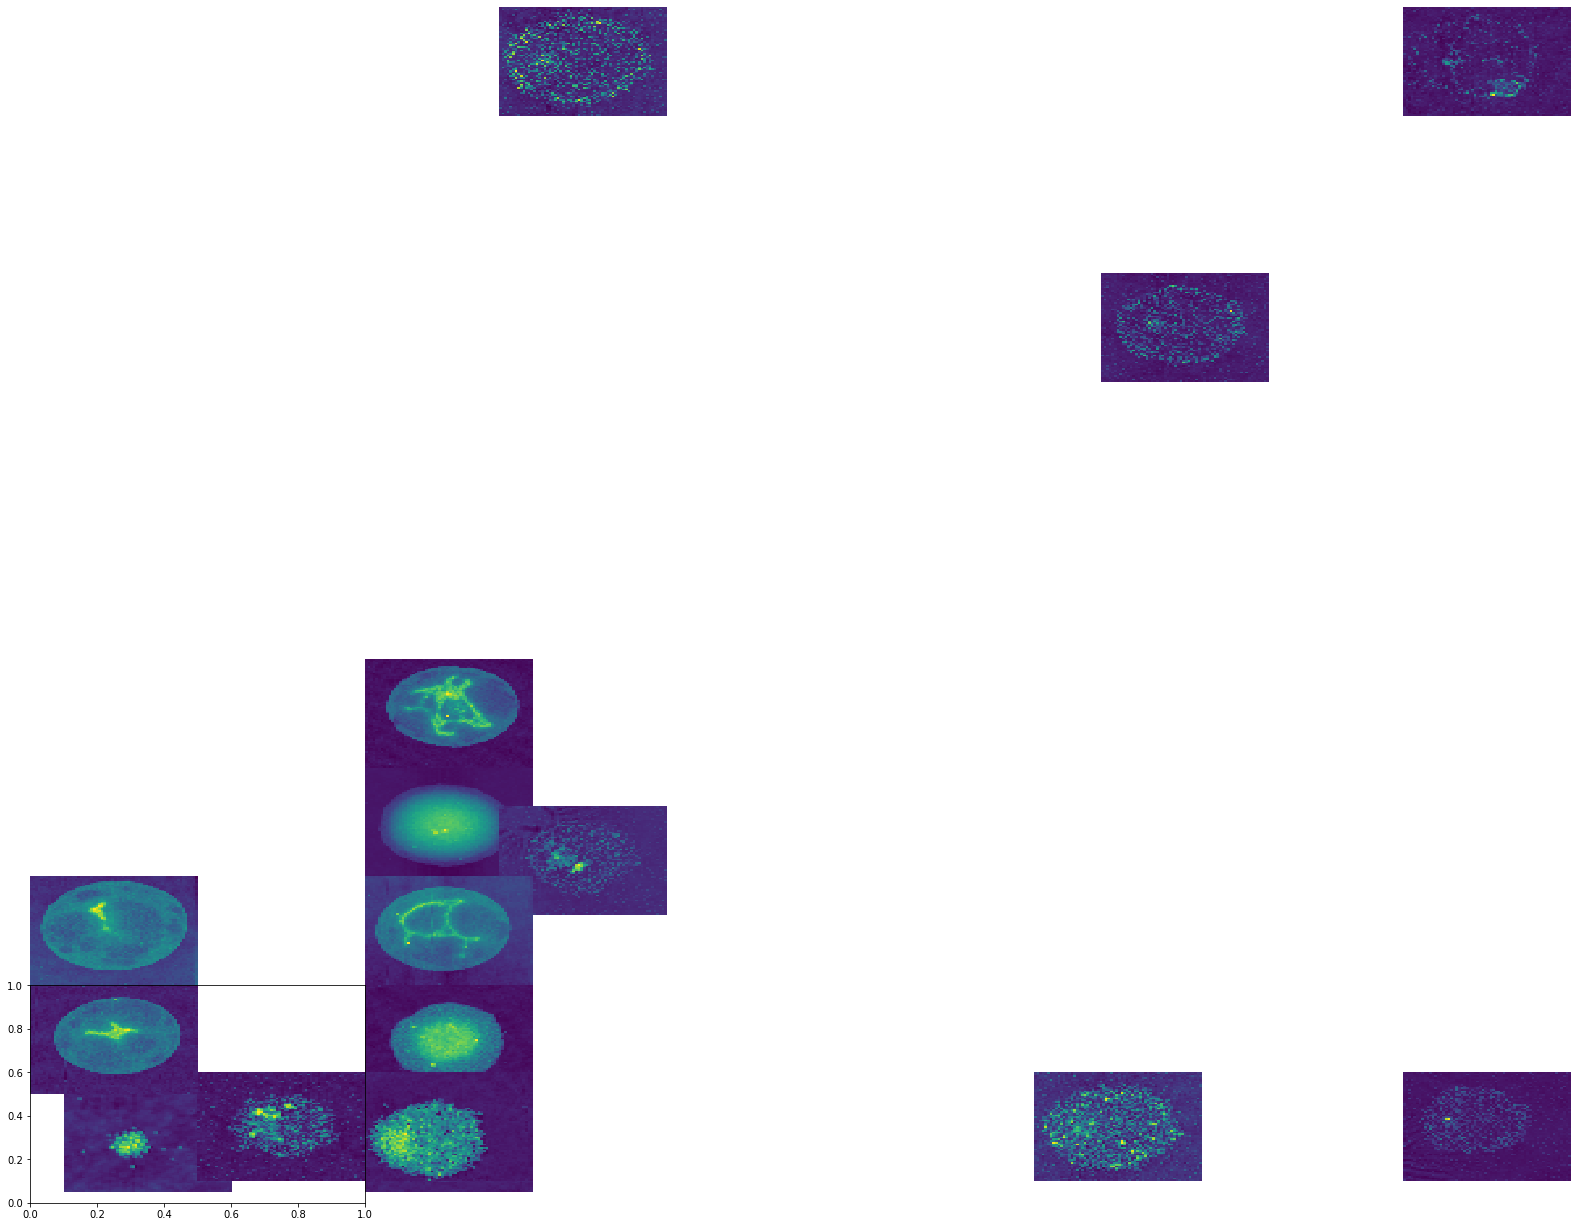

In [7]:
def plot_image(xData, yData, ims):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for idx, (x, y) in enumerate(zip(xData, yData)):
        small_im_dim = 0.5
        bb = Bbox.from_bounds(x, y, small_im_dim, small_im_dim)
        bb2 = TransformedBbox(bb, ax.transData)
        bbox_image = BboxImage(bb2, norm = None,
                              origin=None, clip_on=False)

        bbox_image.set_data(ims[idx])
        bbox_image.set_alpha(1.0)
        ax.add_artist(bbox_image)

# Plot the filters
#plotImage(X_train_embedded[:,0], X_train_embedded[:,1], X.reshape(1024, 28, 28))
data = np.array([np.array(x) for x in dset.ims.values])
data_downsampled = skimage.transform.resize(data, (36, 64, 64))
plot_image(dset.pressure / 100, dset.time, data_downsampled)
plt.show()

# histogram the heights

(array([1.63856e+05, 8.81200e+03, 4.44100e+04, 2.06250e+04, 2.24950e+04,
        1.63300e+03, 1.34000e+02, 9.10000e+01, 5.30000e+01, 3.50000e+01]),
 array([0.00000000e+00, 2.62433688e-09, 5.24867376e-09, 7.87301064e-09,
        1.04973475e-08, 1.31216844e-08, 1.57460213e-08, 1.83703582e-08,
        2.09946950e-08, 2.36190319e-08, 2.62433688e-08]),
 <a list of 10 Patch objects>)

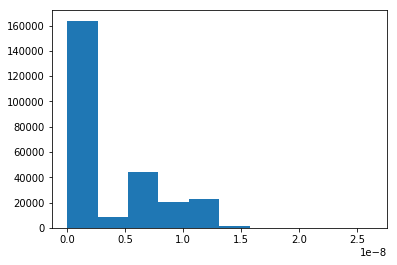

In [12]:
im = dset.ims[0]
plt.hist(im.flatten())

# fit simple curve

maybe try fitting a gaussian: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

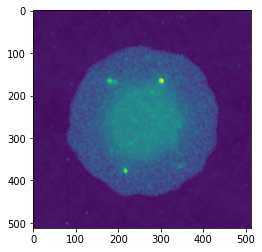

In [4]:
im = dset.ims[0]
plt.imshow(im)

(262144,)


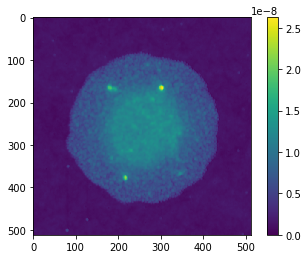

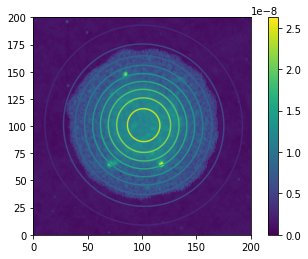

In [34]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

# Create x and y indices
dim = im.shape[0]
x = np.linspace(0, 200, dim)
y = np.linspace(0, 200, dim)
x, y = np.meshgrid(x, y)
data = im.flatten()

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(dim, dim))
plt.colorbar()

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

# data_noisy = data + 0.2*np.random.normal(size=data.shape)
data_noisy = data

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)

data_fitted = twoD_Gaussian((x, y), *popt)

fig, ax = plt.subplots(1, 1)
plt.imshow(data_noisy.reshape(dim, dim), origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()
ax.contour(x, y, data_fitted.reshape(dim, dim), 9) #, colors='r')
plt.show()